In [1]:
import math
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib
import random as rand
from matplotlib import pyplot as plt
from itertools import product
import time
import datetime
import itertools
import time
import re
import csv
from hurst import compute_Hc
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression
import scipy.stats as ss
import matplotlib.ticker as ticker
import yfinance as yf
from scipy.stats import boxcox
import statsmodels.api as sm
import tqdm

%matplotlib inline

In [2]:
plt.rcParams["axes.labelsize"] = 16. 
plt.rcParams["xtick.labelsize"] = 14. 
plt.rcParams["ytick.labelsize"] = 14. 
plt.rcParams["legend.fontsize"] = 12. 
plt.rcParams["figure.figsize"] = [17., 8.]

## Import CSV data
With DDPG agent

In [3]:
#data = yf.download('DJI','2017-06-01','2019-10-01')
# Plot the close price of the AAPL
#data['Adj Close'].plot()
data = pd.read_csv('data/sp500_minute-data.csv').ClosePrice
plt.show()

In [4]:
data_list = pd.read_csv('data/sp500_minute-data.csv').Date
time_list = pd.read_csv('data/sp500_minute-data.csv').Timestamp

In [5]:
pd.read_csv('data/sp500_minute-data.csv').ClosePrice.pct_change().fillna(0)

0         0.000000
1         0.000943
2        -0.000189
3         0.002640
4        -0.002821
            ...   
194317    0.000305
194318   -0.000305
194319    0.000000
194320   -0.000305
194321    0.000000
Name: ClosePrice, Length: 194322, dtype: float64

And without DDPG agent

In [6]:
data.head(7)

0    53.00
1    53.05
2    53.04
3    53.18
4    53.03
5    53.01
6    52.97
Name: ClosePrice, dtype: float64

In [7]:
new_data = []
delta = 0
for i in range(1, len(data.values)):
    if abs(data.values[i] - data.values[i-1]) > 1:
        delta += data.values[i-1] - data.values[i]
    new_data.append(delta + data.values[i])

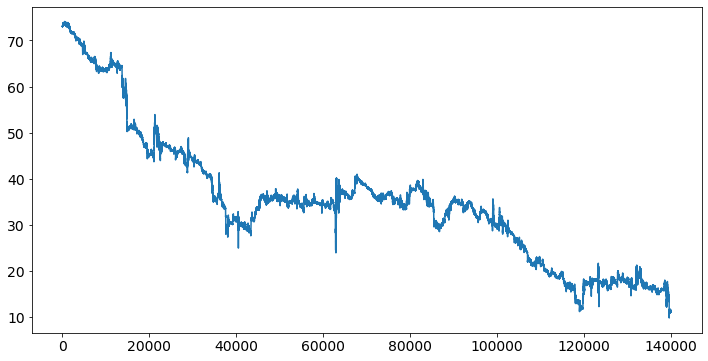

In [40]:
plt.plot(np.array(new_data[:140000])+20)
plt.show()

In [41]:
pd.DataFrame(new_data[:140000]).to_csv('sp500_data.csv')

In [9]:
time_list[:381][::5].values.shape

(77,)

In [10]:
np.arange(0, 140000, 368)[::5].shape

(77,)

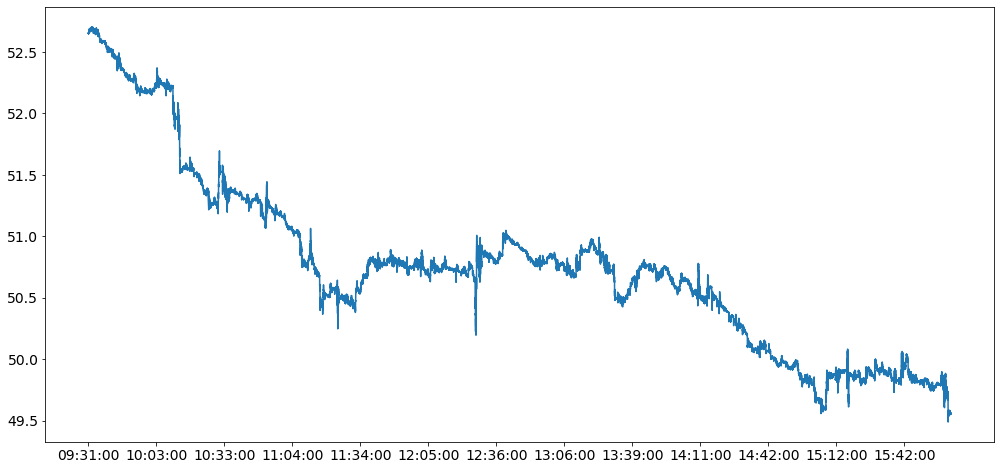

In [11]:
fig, ax = plt.subplots()

ax.plot((np.array(new_data[:140000])/20+50))
#ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
ax.xaxis.set_major_locator(ticker.FixedLocator(np.arange(0, 140000, 368)[::30]))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(time_list[:381][::30].values))
plt.show()

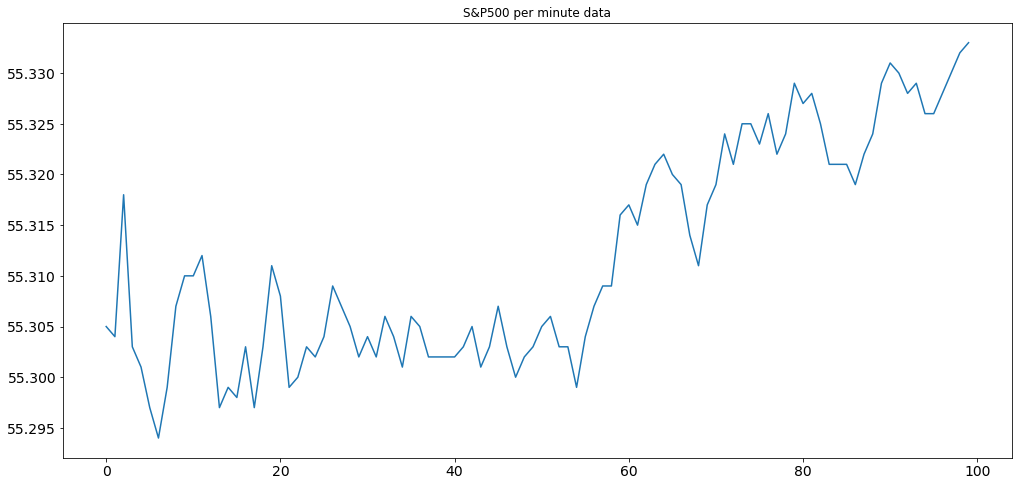

In [12]:
plt.plot((np.array(new_data[:100])/10+50))
plt.title('S&P500 per minute data')
plt.show()

In [13]:
time_list[:2900]

0       09:31:00
1       09:33:00
2       09:34:00
3       09:35:00
4       09:36:00
          ...   
2895    12:49:00
2896    12:50:00
2897    12:51:00
2898    12:52:00
2899    12:53:00
Name: Timestamp, Length: 2900, dtype: object

------
Returns data

In [14]:
data['returns'] = pd.DataFrame(new_data).pct_change()
ddd = pd.DataFrame(data).pct_change()

### DDPG price and returns

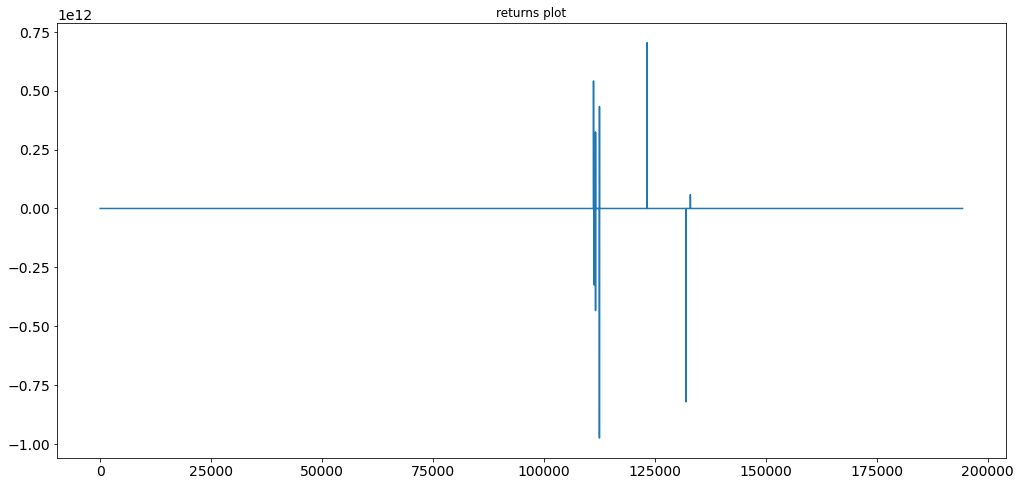

In [15]:
plt.plot(data['returns'])
plt.title('returns plot')
plt.show()

### Default price and returns

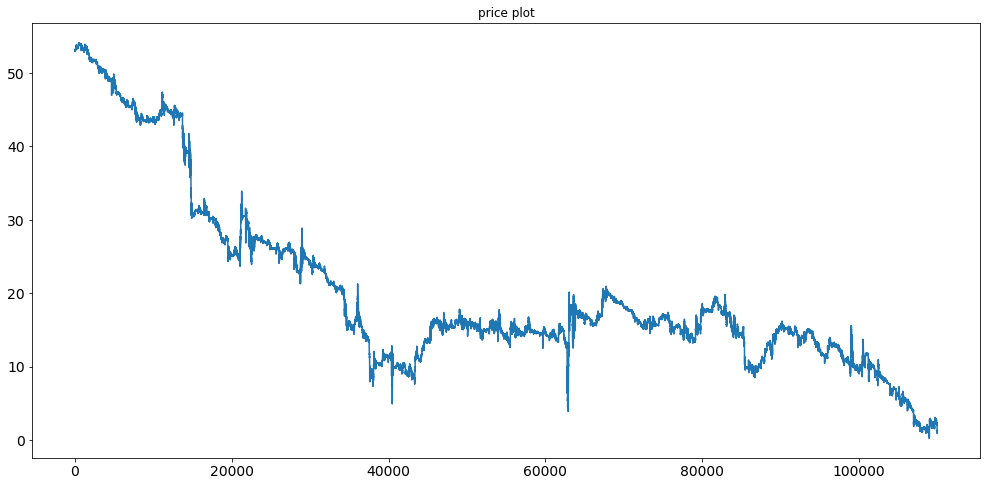

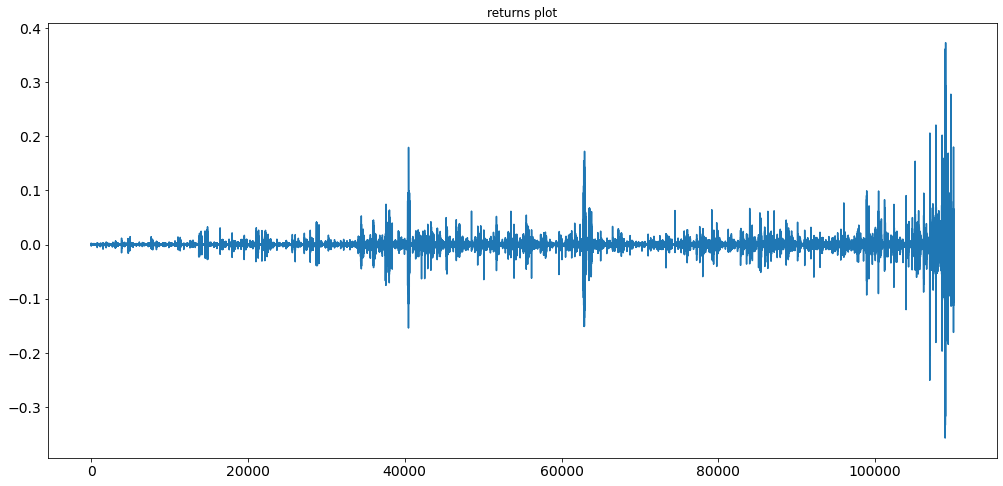

In [16]:
plt.plot(new_data[:110000])
plt.title('price plot')
plt.show()

plt.plot(data['returns'][:110000])
plt.title('returns plot')
plt.show()

-------
## Fat tailed distribution 

Let use kurtosis value (4'th moment) to calculate value of the tail of returns

In [17]:
kurt_list_default = [pd.DataFrame(new_data[:30000]).pct_change(k).kurt() for k in range(3000)]

In [18]:
pd.DataFrame(new_data[:30000]).pct_change().kurt()

0    31.976059
dtype: float64

In [19]:
pd.DataFrame(ss.norm.rvs(0, 1, 1000000)).kurt()

0   -0.003529
dtype: float64

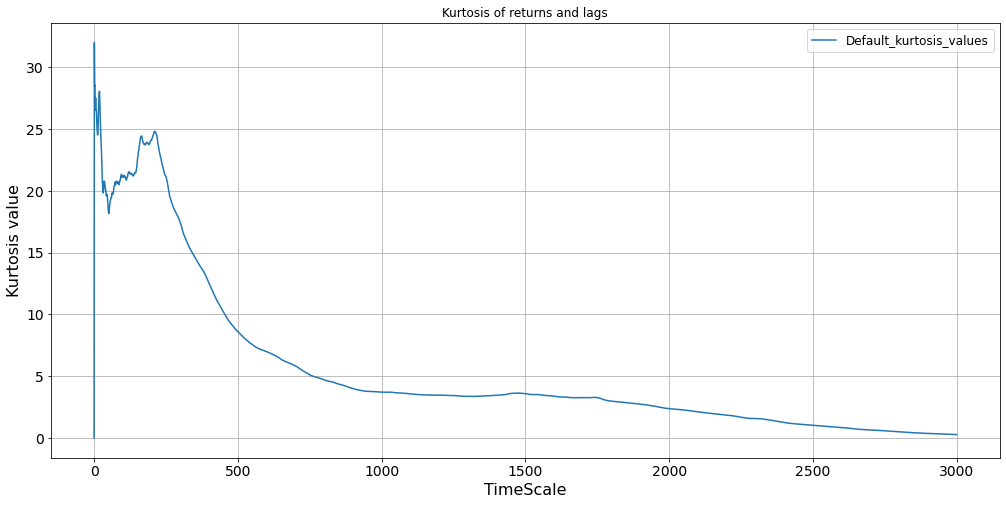

In [20]:
plt.plot(kurt_list_default[:], label = 'Default_kurtosis_values')
plt.title('Kurtosis of returns and lags')
plt.xlabel('TimeScale')
plt.ylabel('Kurtosis value')
plt.grid(True)
plt.legend()
plt.show()

Along the abscissa axis, the kurtosis value readings are plotted depending on the degree of differentiation of the series

------
## Volatility clustering comparing  

We can use autocorrealtion of squared returns function as measure of volatility clustering (ARCH effect)  

Also we can use returns in other degrees to calculate other data (GARCH effect).

Default plot

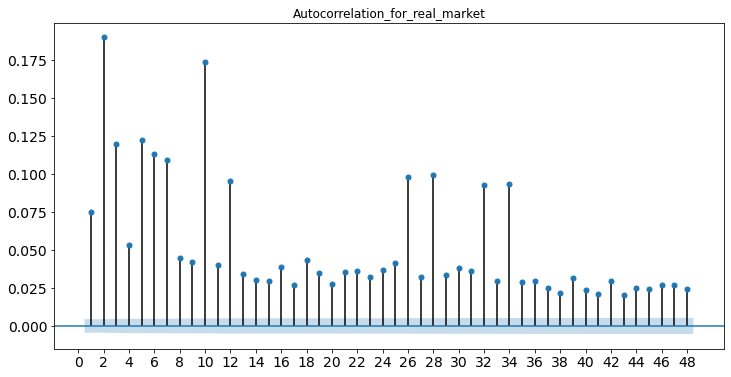

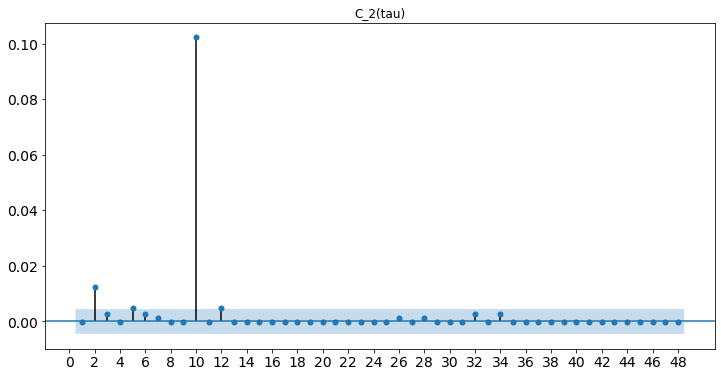

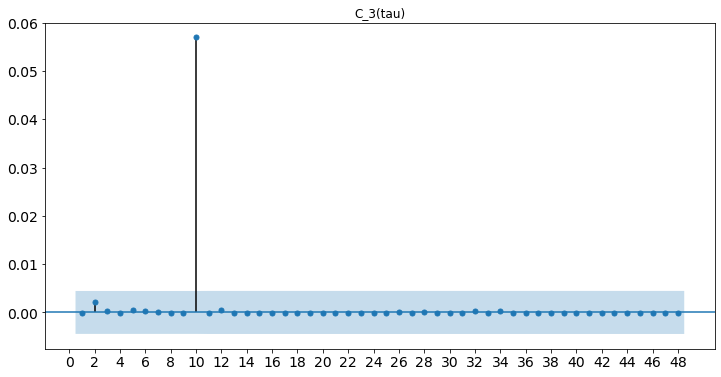

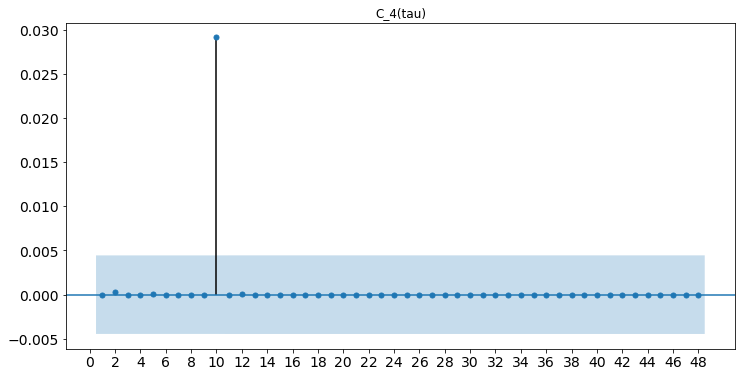

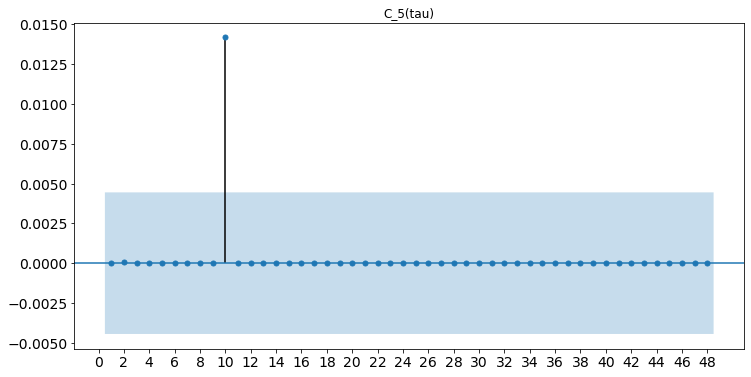

In [21]:
plt.rcParams['figure.figsize'] = (12,6)
plot_acf(np.log(1+abs(data['returns'].fillna(0))), lags=48, zero = False)
plt.xticks(np.arange(0, 50, 2))
plt.title('Autocorrelation_for_real_market')
plt.show()

plt.rcParams['figure.figsize'] = (12,6)
plot_acf(data['returns'].fillna(0)**2, lags=48, zero = False)
plt.xticks(np.arange(0, 50, 2))
plt.title('C_2(tau)')
plt.show()

plt.rcParams['figure.figsize'] = (12,6)
plot_acf(abs(data['returns'].fillna(0)**3), lags=48, zero = False)
plt.xticks(np.arange(0, 50, 2))
plt.title('C_3(tau)')
plt.show()

plt.rcParams['figure.figsize'] = (12,6)
plot_acf(abs(data['returns'].fillna(0)**4), lags=48, zero = False)
plt.xticks(np.arange(0, 50, 2))
plt.title('C_4(tau)')
plt.show()

plt.rcParams['figure.figsize'] = (12,6)
plot_acf(abs(data['returns'].fillna(0)**5), lags=48, zero = False)
plt.xticks(np.arange(0, 50, 2))
plt.title('C_5(tau)')
plt.show()

Сумма квадров лагов автокорреляции должна сходиться к нормальной величине.

In [22]:
(data['returns'].fillna(0)**2).values.reshape(-1) + np.random.random(data['returns'].shape[0])/10

array([0.06082395, 0.01952759, 0.01841275, ..., 0.01800957, 0.0245613 ,
       0.09241632])

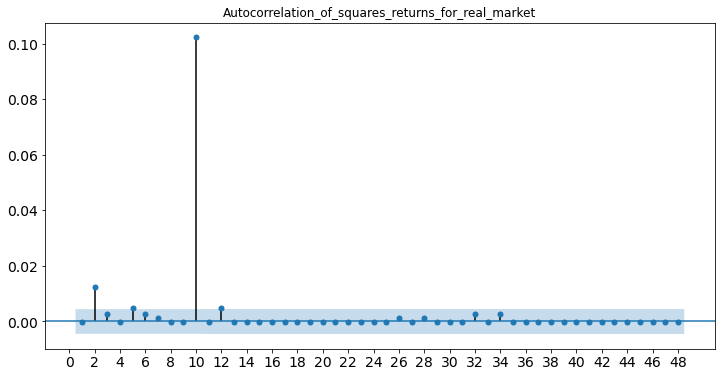

In [23]:
plt.rcParams['figure.figsize'] = (12,6)
plot_acf((data['returns'].fillna(0)**2).values.reshape(-1), 
         lags=48, zero = False)
plt.xticks(np.arange(0, 50, 2))
plt.title('Autocorrelation_of_squares_returns_for_real_market')
plt.show()

In [24]:
pd.read_csv('data/sp500_minute-data.csv').ClosePrice.pct_change().fillna(0)

0         0.000000
1         0.000943
2        -0.000189
3         0.002640
4        -0.002821
            ...   
194317    0.000305
194318   -0.000305
194319    0.000000
194320   -0.000305
194321    0.000000
Name: ClosePrice, Length: 194322, dtype: float64

-----
## Autocorrelation of returns

We'll observe simple linear cutocorrelation of returns and squared autocorrelation of returns.

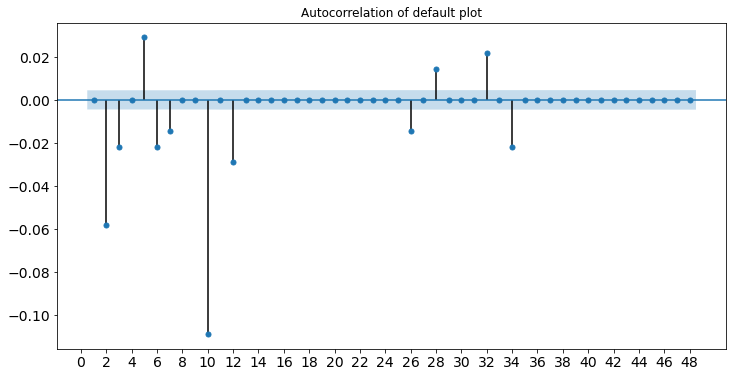

Dickey—Fuller_test_value: p=0.000000


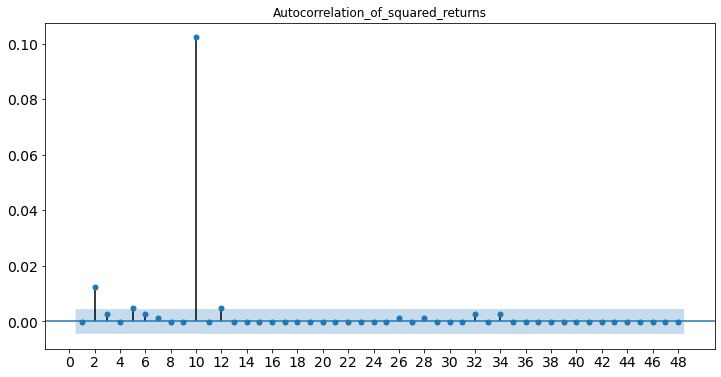

Dickey—Fuller_test_value: p=0.000000


In [25]:
plt.rcParams['figure.figsize'] = (12,6)
plot_acf(data['returns'].fillna(0), lags=48, zero = False)
plt.xticks(np.arange(0, 50, 2))
plt.title('Autocorrelation of default plot')
plt.show()
print('Dickey—Fuller_test_value: p=%f' % adfuller(data['returns'].fillna(0))[1])

########

plt.rcParams['figure.figsize'] = (12,6)
plot_acf(data['returns'].fillna(0)**2, lags=48, zero = False)
plt.xticks(np.arange(0, 50, 2))
plt.title('Autocorrelation_of_squared_returns')
plt.show()
print('Dickey—Fuller_test_value: p=%f' % adfuller(data['returns'].fillna(0)**2)[1])

----
## Q-Q plot values  
Here we use Q-Q plot to observe comparisons of sampled quantiles obtained during the implementation of our process with the normal distribution (???)  (Normal or Gaussian, what will be better?)

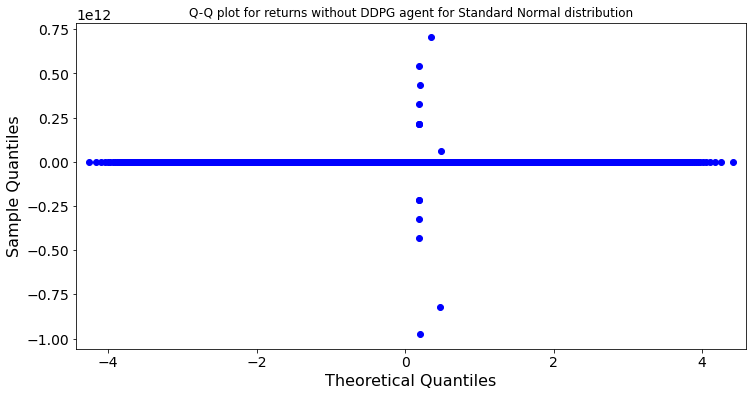

In [26]:
sm.qqplot(data['returns'])
plt.title('Q-Q plot for returns without DDPG agent for Standard Normal distribution')
plt.show()

------
### ECDF Plotting  

Let build empirical cumulative distribution function (ECDF) to compare 2 cumulative distributions

In [27]:
from statsmodels.distributions.empirical_distribution import ECDF

In [28]:
ecdf_default = ECDF(data['returns'].fillna(0).values.reshape(-1))

In [29]:
arr_real = []
for k in data['returns'].fillna(0).values.reshape(-1):
    if abs(k)>0:
        arr_real.append(k)


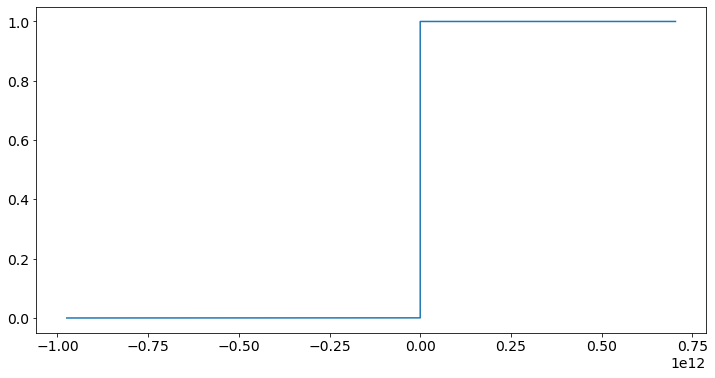

In [30]:
plt.plot(ecdf_default.x, ecdf_default.y)
plt.show()

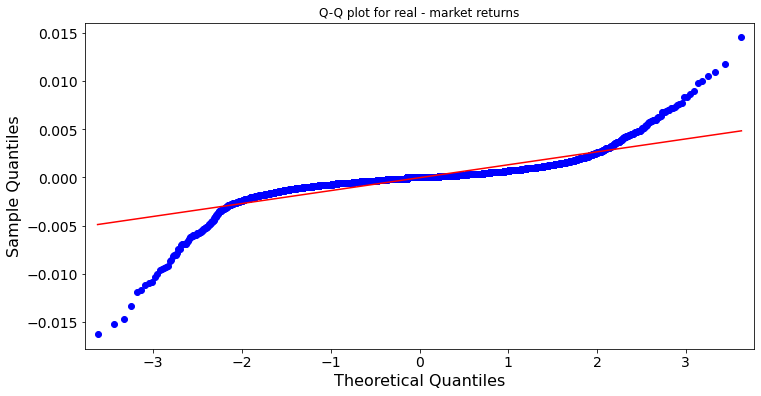

In [31]:
sm.qqplot(np.hstack((np.array(arr_real)[:6000], [0]*1000)), line = 's')
plt.title('Q-Q plot for real - market returns')
plt.show()

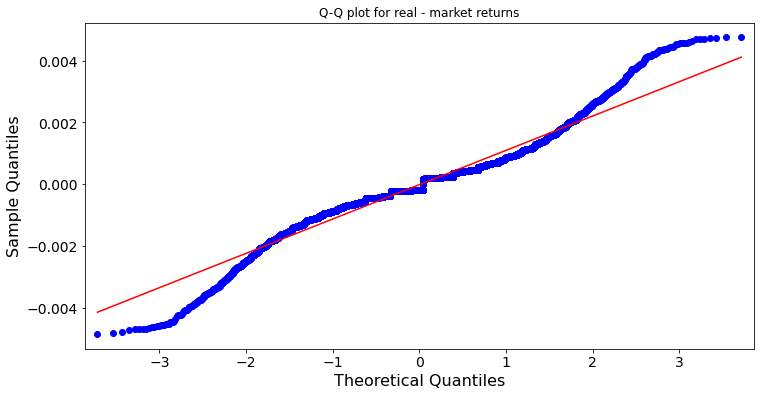

In [32]:
sm.qqplot(np.sort(arr_real[:10000])[100:-100], line = 's')
plt.title('Q-Q plot for real - market returns')
plt.show()

In [33]:
np.hstack((np.array(arr_real)[:10000], [0]*100))

array([-0.0001885 ,  0.00263952, -0.00282061, ...,  0.        ,
        0.        ,  0.        ])

Сделать. PDF plotting (можно сделать как гистограмму)

------
## Hill estimating  
for returns!

In [34]:
statistics_order = np.sort(data['returns'].fillna(0))

Do we want to use module values here?  
Что делать если у нас в порядковых статистиках нули? (я ко всему ряду прибавил 1)

In [35]:
hill_estimator_default = lambda k: 1/k*np.sum(np.log(abs(np.sort(
    data['returns'].fillna(0))))[:k]) - np.log(
    abs(np.sort(data['returns'].fillna(0))))[k]

#Add one number

hill_estimator_default_one = lambda k: 1/k*np.sum(np.log(abs(np.sort(
    data['returns'].fillna(0))[::-1]+1))[:k]) - np.log(
    abs(np.sort(data['returns'].fillna(0))[::-1]+1))[k]

In [36]:
len(data['returns'])

194321

<ipython-input-35-e0d7e6ee1b8d>:1: RuntimeWarning: divide by zero encountered in log
  hill_estimator_default = lambda k: 1/k*np.sum(np.log(abs(np.sort(
<ipython-input-35-e0d7e6ee1b8d>:2: RuntimeWarning: divide by zero encountered in log
  data['returns'].fillna(0))))[:k]) - np.log(
<ipython-input-35-e0d7e6ee1b8d>:1: RuntimeWarning: invalid value encountered in subtract
  hill_estimator_default = lambda k: 1/k*np.sum(np.log(abs(np.sort(


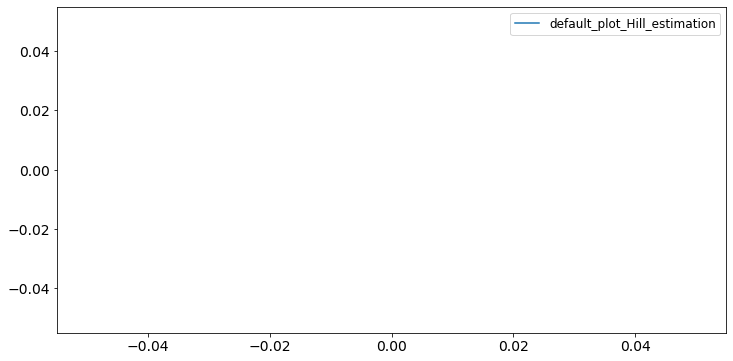

In [37]:
plt.plot([hill_estimator_default(t) for t in range(1, 500)], label = 'default_plot_Hill_estimation')
plt.legend()
plt.show()

Добавить 1 и 5 процентов